<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [2]:
pth1 = '/datasets/taxi.csv'
pth2 = 'https://code.s3.yandex.net/datasets/taxi.csv'

if os.path.exists(pth1):
    data= pd.read_csv(pth1, parse_dates=[0], index_col=[0])
elif os.path.exists(pth2):
    data= pd.read_csv(pth2, parse_dates=[0], index_col=[0])
else:
    print('Something is wrong')
    
display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
# проверяем наличие пропущенных значений в датафреймах
data.isna().sum()

num_orders    0
dtype: int64

In [5]:
# отсортируем индекс
data = data.sort_index()
# проверим, в хронологическом ли порядке расположены даты и время
print(data.index.is_monotonic)

True


In [6]:
# ресемплируем данные по 1 часу
data = data.resample('1H').sum()

Выводы:

В датафрейме data 26496 записей, названия столбцов адекватны содержащимся в них данным. Было проверено, нет ли пропущенных значений. Данные расположены в хронологическом порядке. Данные были ресемплированы по 1 часу. Данные готовы к анализу.

## Анализ

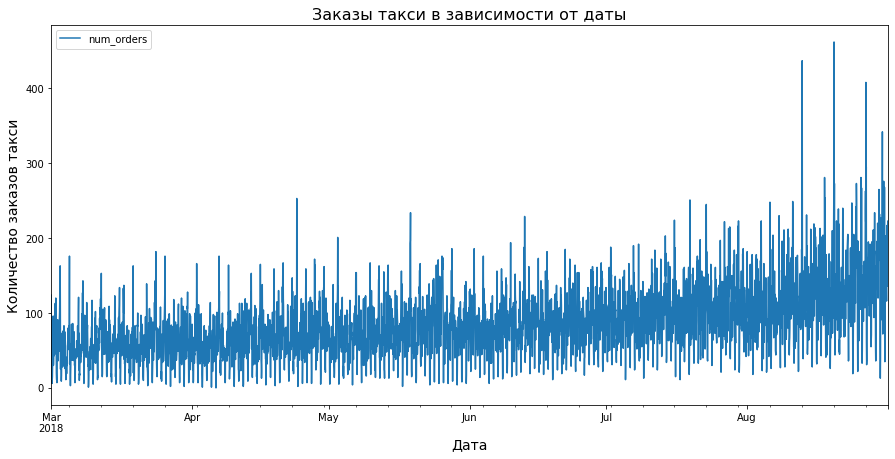

In [7]:
# построим график временного ряда
data.plot(figsize=(15,7))
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14)
plt.title('Заказы такси в зависимости от даты', fontsize=16)
plt.legend()
plt.show();

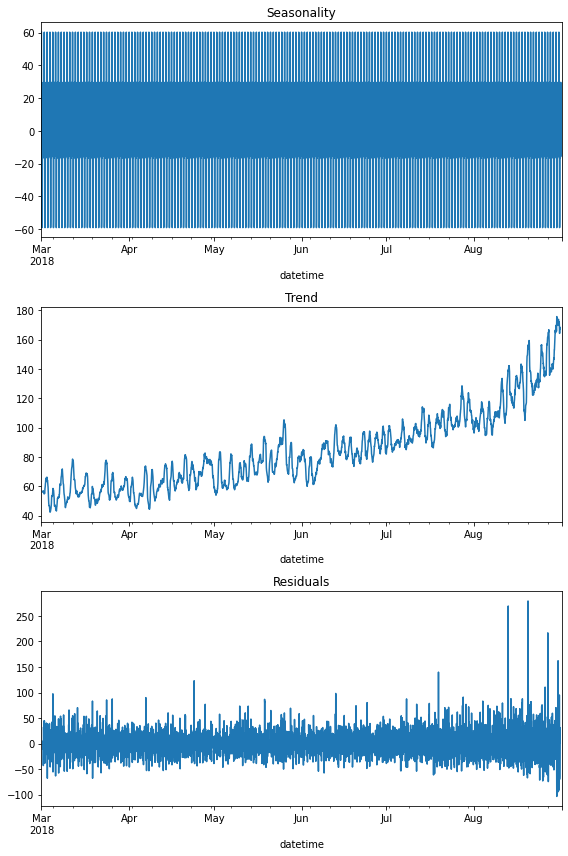

In [8]:
# разложим временной ряд на тренд и сезонность
decomposed = seasonal_decompose(data)

plt.figure(figsize=(8, 12))
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

В течение года заказов становилось больше.

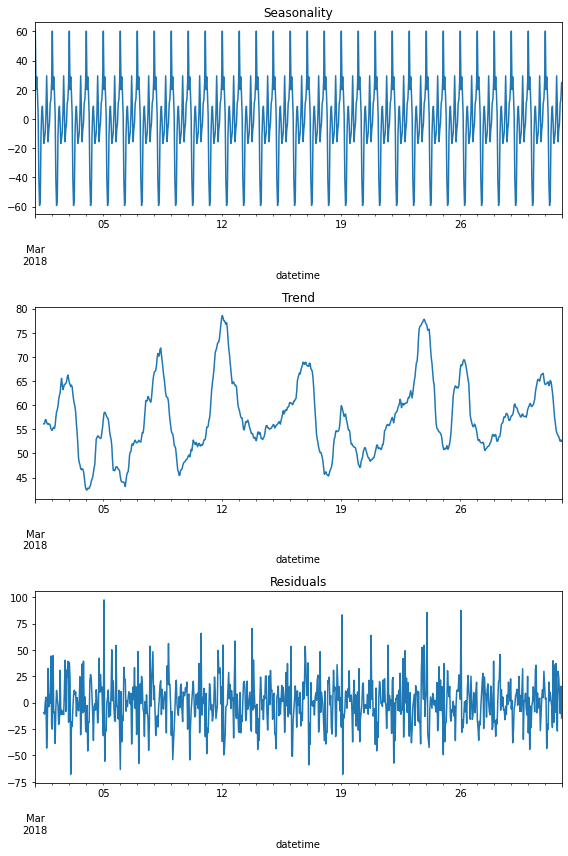

In [9]:
# построим график сезонной составляющей за март
plt.figure(figsize=(8, 12))
plt.subplot(311)
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(312)
decomposed.trend['2018-03-01':'2018-03-31'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(313)
decomposed.resid['2018-03-01':'2018-03-31'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

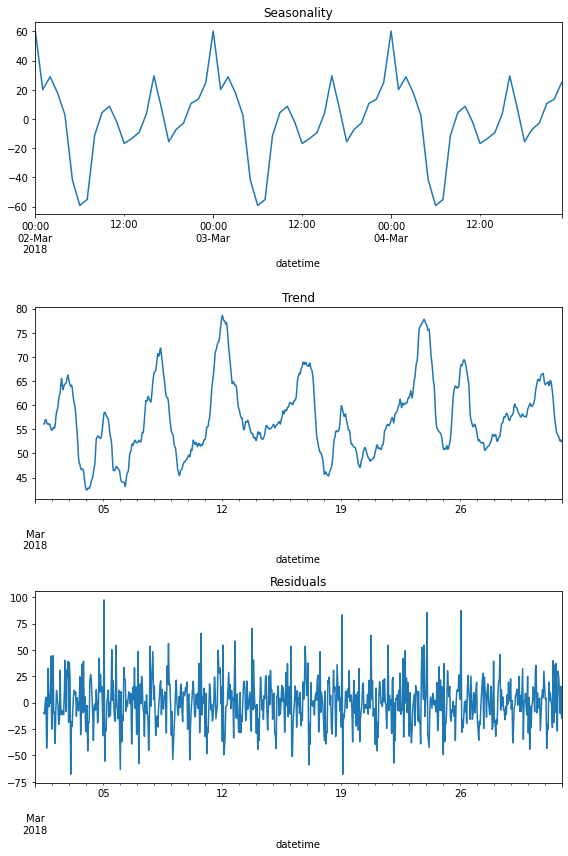

In [10]:
# построим график сезонной составляющей за март и за двое суток в марте
plt.figure(figsize=(8, 12))
plt.subplot(311)
decomposed.seasonal['2018-03-02':'2018-03-04'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(312)
decomposed.trend['2018-03-01':'2018-03-31'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(313)
decomposed.resid['2018-03-01':'2018-03-31'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Максимум заказов в 0:00.

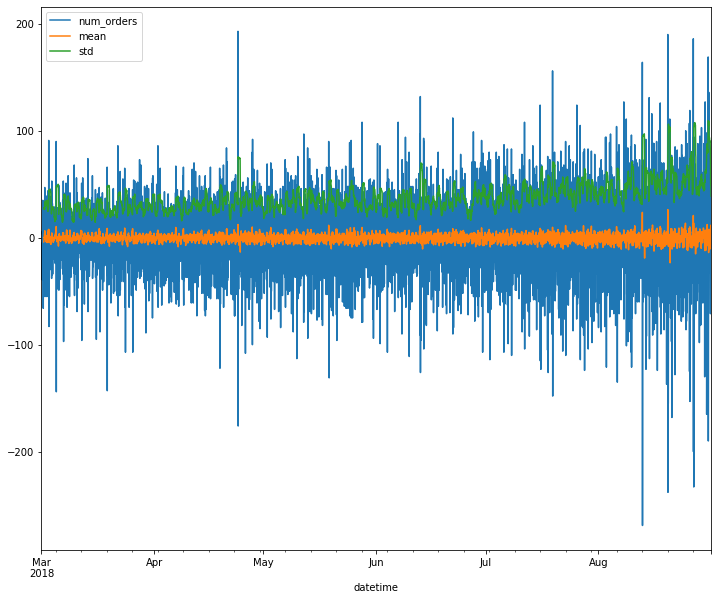

In [11]:
# проверим стационарность временного ряда
data1 = data - data.shift()
data1['mean'] = data1['num_orders'].rolling(15).mean()
data1['std'] = data1['num_orders'].rolling(15).std()
data1.plot(figsize=(12,10))
plt.show()

По графику видно, что ряд достаточно стационарен, поскольку его среднее значение и стандартное отклонение не сильно меняются.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    # Создаем копию датафрейма
    df = data.copy()
    
    # Добавляем новые признаки
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour  # Используем hour для часа

    # Вычислим отстающие значения
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    # Вычислим скользящее среднее и добавим его как признак 'rolling_mean'
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    # Возвращаем модифицированный датафрейм
    return df

# Зададим отстающие признаки 24, а скользящее среднее 10
features_df = make_features(data, 24, 10)

# Печать результата
print(features_df.head())

                     num_orders  month  day  dayofweek  hour  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         124      3    1          3     0    NaN    NaN   
2018-03-01 01:00:00          85      3    1          3     1  124.0    NaN   
2018-03-01 02:00:00          71      3    1          3     2   85.0  124.0   
2018-03-01 03:00:00          66      3    1          3     3   71.0   85.0   
2018-03-01 04:00:00          43      3    1          3     4   66.0   71.0   

                     lag_3  lag_4  lag_5  ...  lag_16  lag_17  lag_18  lag_19  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00  124.0    NaN    NaN  ...   

In [13]:
# удалим пропуски
features_df.dropna(inplace=True)

In [14]:
features_df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,61.7
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,65.9
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,71.3
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,74.5
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,76.5


Выводы:

Были проанализированы графики временного ряда, сначала по всем данным, по 1 месяцу (март) и по 2 дням в марте. Было выявлено, что максимум заказов приходится на 0:00. Временной ряд был проверен на стационарность. Были созданы календарные признаки для месяца, дня, дня недели и часа и отстающие признаки, а также скользящее среднее. Были удалены пропуски. Данные готовы к обучению.

## Обучение

In [15]:
# разделим выборки на обучающую и тестовую
train, test = train_test_split(features_df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
 
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

# проверим размер выборок
display(train.shape)
display(test.shape)
# проверим корректность деления
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

(3952, 30)

(440, 30)

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


Модель LinearRegression

In [16]:
model = LinearRegression()
model.fit(features_train, target_train)
train_pred = model.predict(features_train)
rmse = mean_squared_error(target_train, train_pred)**0.5
print(rmse)

25.7046127959676


Модель DecisionTreeRegressor

In [17]:
#разделим данные на обучающую и тестовые выборки
#на обучающую выделим 80%, на тестовую - 20%
train_dt, test_dt = train_test_split(features_df, test_size=0.20, shuffle=False, random_state=12345) 

# #создадим в обучающей выборке переменные для признаков и целевого признака 
features_train_dt = train_dt.drop(['num_orders'], axis=1)
target_train_dt = train_dt['num_orders']

# #разделим тестовую выборку пополам на тестовую и валидационную
valid_dt, test_dt = train_test_split(test_dt, test_size=0.50, random_state=12345)

# #создадим в валидационной и тестовой выборках переменные для признаков и целевого признака
features_valid_dt = valid_dt.drop(['num_orders'], axis=1)
target_valid_dt = valid_dt['num_orders']
features_test_dt = test_dt.drop(['num_orders'], axis=1)
target_test_dt = test_dt['num_orders']

#проверим, как поделились выборки
print(train_dt.shape)
print(test_dt.shape)
print(valid_dt.shape)

(3513, 30)
(440, 30)
(439, 30)


In [18]:
# найдем лучшие гиперпараметры для глубины дерева
for depth in range(1,13,2):
    model = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    model.fit(features_train_dt, target_train_dt)
    predictions_valid_dt = model.predict(features_valid_dt)
    rmse = mean_squared_error(target_valid_dt, predictions_valid_dt)**0.5
    print('Глубина:', depth)
    print('RMSE для решающего дерева:', rmse)
    print('')
print()

Глубина: 1
RMSE для решающего дерева: 67.02783511753934

Глубина: 3
RMSE для решающего дерева: 58.55415129313441

Глубина: 5
RMSE для решающего дерева: 49.27184012451867

Глубина: 7
RMSE для решающего дерева: 49.85467647963641

Глубина: 9
RMSE для решающего дерева: 53.187090581087624

Глубина: 11
RMSE для решающего дерева: 55.18522712233746




Модель RandomForestRegressor

In [19]:
for depth in range(1,13, 2):
    model = RandomForestRegressor(random_state=12345, max_depth = depth)
    model.fit(features_train_dt, target_train_dt)
    predictions_valid_dt = model.predict(features_valid_dt)
    rmse = mean_squared_error(target_valid_dt, predictions_valid_dt)**0.5
    print('Глубина:', depth)
    print('RMSE для RandomForestRegressor:', rmse)
    print('')
print()

Глубина: 1
RMSE для RandomForestRegressor: 65.32484931983134

Глубина: 3
RMSE для RandomForestRegressor: 56.455460970194395

Глубина: 5
RMSE для RandomForestRegressor: 46.26250684055831

Глубина: 7
RMSE для RandomForestRegressor: 43.23765607927583

Глубина: 9
RMSE для RandomForestRegressor: 41.54590180956876

Глубина: 11
RMSE для RandomForestRegressor: 41.26220992549378




Модель LGBM

In [20]:
# проверим модель без подбора гиперпараметров
model = lgb.LGBMRegressor(random_state=12345)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print(rmse)

39.69883526487641


In [21]:
# найдем наилучшие гиперпараметры
param_grid = {'num_leaves':[10,50,70], 'learning_rate':[0.1,0.3,0.5]}

In [22]:
tuning_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=TimeSeriesSplit(),
                          verbose=3)

tuning_model.fit(features_train, target_train)
display(tuning_model.best_params_)
display(tuning_model.best_score_*-1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ...............learning_rate=0.1, num_leaves=10; total time=   0.4s
[CV 2/5] END ...............learning_rate=0.1, num_leaves=10; total time=   1.2s
[CV 3/5] END ...............learning_rate=0.1, num_leaves=10; total time=   0.7s
[CV 4/5] END ...............learning_rate=0.1, num_leaves=10; total time=   1.3s
[CV 5/5] END ...............learning_rate=0.1, num_leaves=10; total time=   1.6s
[CV 1/5] END ...............learning_rate=0.1, num_leaves=50; total time=   2.2s
[CV 2/5] END ...............learning_rate=0.1, num_leaves=50; total time=   2.4s
[CV 3/5] END ...............learning_rate=0.1, num_leaves=50; total time=   3.2s
[CV 4/5] END ...............learning_rate=0.1, num_leaves=50; total time=   3.2s
[CV 5/5] END ...............learning_rate=0.1, num_leaves=50; total time=   4.7s
[CV 1/5] END ...............learning_rate=0.1, num_leaves=70; total time=   1.5s
[CV 2/5] END ...............learning_rate=0.1, nu

{'learning_rate': 0.1, 'num_leaves': 10}

24.769964223283786

Выводы:
    
Мы разделили данные на обучающую и тестовую выборки и обучили модели линейной регрессии, случайного леса и LightGBM. Наилучшее значение метрики RMSE оказалось у LightGBM - 24.7. Наилучшие параметры: 'learning_rate': 0.1, 'num_leaves': 10. Для LinearRegression RMSE - 25.7, для модели DecisionTreeRegressor при max_depth 11 RMSE - 55.1, для модели RandomForestRegressor при max_depth 11 - 41.2.

## Тестирование

In [23]:
# протестируем наилучшую модель на тестовой выборке
model = lgb.LGBMRegressor(random_state=12345, learning_rate = 0.1, num_leaves=10)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print(rmse)

40.79458113890631


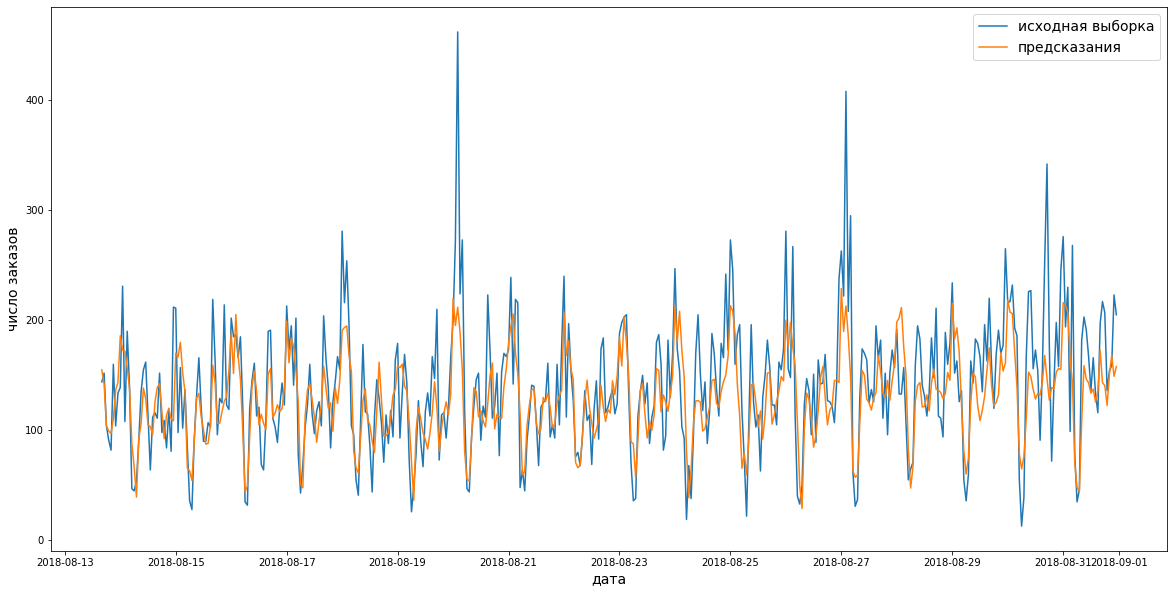

In [24]:
# построим график для исходных данных и для предсказанных
predictions_test = pd.Series(predictions_test, index=target_test.index)
plt.figure(figsize=(20,10))
plt.xlabel('дата', fontsize=14)
plt.ylabel('число заказов',fontsize=14)
plt.plot(target_test, label='исходная выборка')
plt.plot(predictions_test, label='предсказания')
plt.legend(fontsize=14)
plt.show()

Выводы: 

Показатель RMSE на тестовой выборке дал значение 40.7. На графике видно, что модель предсказывает адекватно, но по всплескам видно, что она ошибается в некоторых местах.

Общие выводы:

В датафрейме data 26496 записей, названия столбцов адекватны содержащимся в них данным. Было проверено, нет ли пропущенных значений. Данные расположены в хронологическом порядке. Данные были ресемплированы по 1 часу. Данные готовы к анализу.

Были проанализированы графики временного ряда, сначала по всем данным, по 1 месяцу (март) и по 2 дням в марте. Было выявлено, что максимум заказов приходится на 0:00. Временной ряд был проверен на стационарность. Были созданы календарные признаки для месяца, дня, дня недели и часа и отстающие признаки, а также скользящее среднее. Были удалены пропуски. Данные готовы к обучению.

Мы разделили данные на обучающую и тестовую выборки и обучили модели линейной регрессии, случайного леса и LightGBM. Наилучшее значение метрики RMSE оказалось у LightGBM - 24.7. Наилучшие параметры: 'learning_rate': 0.1, 'num_leaves': 10. Для LinearRegression RMSE - 25.7, для модели DecisionTreeRegressor при max_depth 11 RMSE - 55.1, для модели RandomForestRegressor при max_depth 11 - 41.2.
    
Показатель RMSE на тестовой выборке дал значение 40.7. На графике видно, что модель предсказывает адекватно, но по всплескам видно, что она ошибается в некоторых местах.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48